In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt 
import jax.numpy as jnp
from jax import random
from numpyro.infer import Predictive
from reusable.util import load_samples, gen_file_name, get_decoder_params, load_args, load_training_state, save_samples, load_training_history
from reusable.gp import BuildGP
from reusable.mcmc import vae_mcmc, run_mcmc
from reusable.geo import get_temp_data
from plotting.plots import plot_draws, compare_draws, plot_one_inference
from plotting.ny import plot_multi_on_state, plot_on_state, mask_for_plotting
import numpyro

numpyro.set_host_device_count(4)


/home/max/mambaforge/envs/jax_numpyro_env/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_49949/2074180396.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/l

In [2]:
args = load_args(19, 1, 5)
rng_key = random.PRNGKey(3)
if "n" not in args:
    args["n"] = args["x"].shape[0]

    
rng_key, rng_key_init, rng_key_init_state, rng_key_plots = random.split(rng_key, 4)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
import pyreadr
import pandas

df= pandas.DataFrame({"y_obs": args["ground_truth_y_obs"], "obs_idx": args["obs_idx"]})
pyreadr.write_rds(f"data/state_{args['state']}_{args['year']}_{args['aggr_method']}_observations.rds", df)

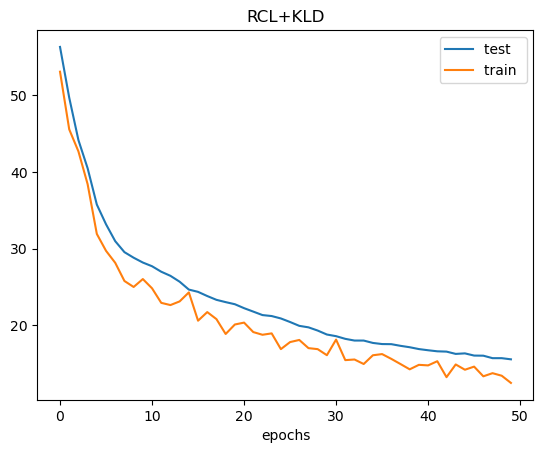

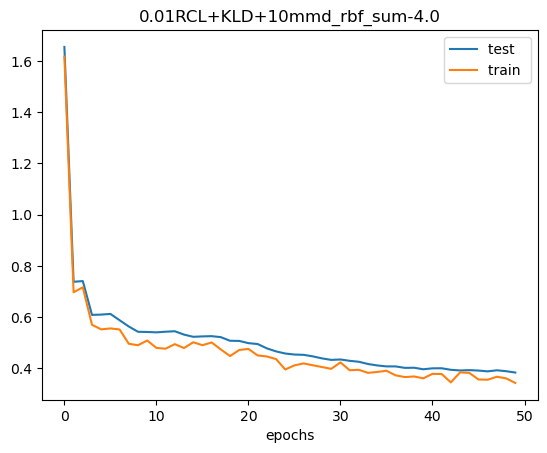

In [4]:
from plotting.plots import plot_training



for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    try:
        metrics_hist = load_training_history(args["expcode"], gen_file_name(args["expcode"], args, loss_fn))
        plot_training(metrics_hist["test_loss"], metrics_hist["train_loss"], loss_fn)
    
    except FileNotFoundError:
        continue


## Comparing GP to PriorVAE draws

In [5]:
should_load_samples = False
to_plot = 200

data_file_name = gen_file_name(args["expcode"], args, f"gp_plot_{to_plot}", data_only=True)

if should_load_samples:
    gp_plot_samples = load_samples(19, data_file_name)
else:
    
    gp = BuildGP(
            args["gp_kernel"],
            noise=False,
            length_prior_choice=args["length_prior_choice"],
            length_prior_args=args["length_prior_arguments"],
            variance_prior_choice=args["variance_prior_choice"],
            variance_prior_args=args["variance_prior_arguments"],
        )

    print("Starting GP")

    gp_plot_pred = Predictive(gp, num_samples=to_plot)
    gp_plot_samples = gp_plot_pred(rng_key_plots, args["x"], jitter=5e-5)

    print("Done GP")
    save_samples(args["expcode"], data_file_name , gp_plot_samples)

Mean 10.5 Variance 21.0
Starting GP


KeyboardInterrupt: 

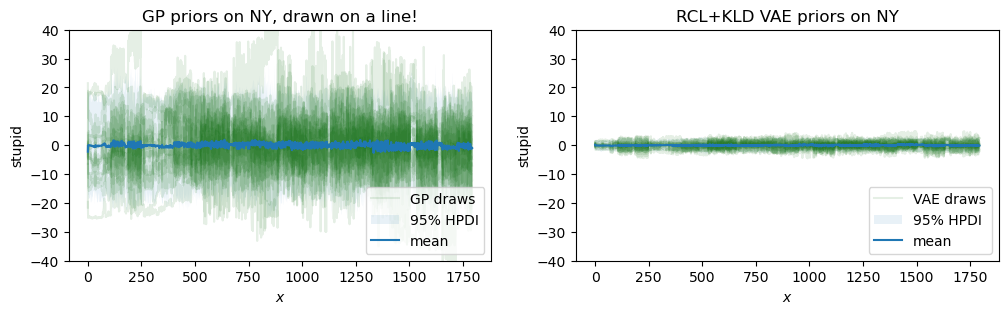

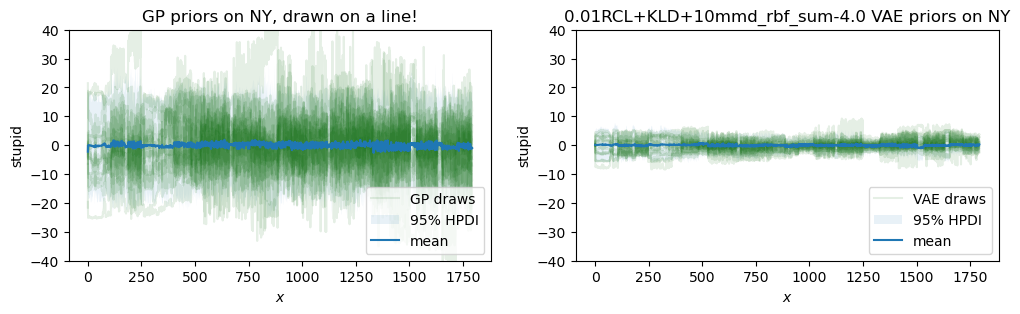

In [ ]:
from plotting.plots import compare_draws
from reusable.vae import VAE
import optax
from reusable.train_nn import SimpleTrainState

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["x"].shape[0],
    conditional=True,
)
params = module.init(rng_key_init, jnp.ones((args["batch_size"], args["n"],)))[
    "params"
]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
dummy_state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init_state)

samples = {}

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    file_name = gen_file_name(args["expcode"], args, loss_fn, "C")

    decoder_params = get_decoder_params(load_training_state(args["expcode"], file_name, dummy_state))   

    vae=vae_mcmc(
            args["hidden_dim1"],
            args["hidden_dim2"],
            args["latent_dim"],
            decoder_params,
            obs_idx=None,
            noise=False,
        )

    

    cvae_plot_pred = Predictive(vae, num_samples=to_plot)
    samples[loss_fn] = cvae_plot_pred(rng_key_plots, args["x"], jitter=5e-5)
    compare_draws(
        jnp.arange(0, args["x"].shape[0]),
        gp_plot_samples["y"],
        samples[loss_fn]["f"],
        "GP priors on NY, drawn on a line!",
        f"{loss_fn} VAE priors on NY",
        "stupid",
        "stupid",
        "GP",
        "VAE",
        _min=-40,
        _max=40
    )

(8, 1794)
(8, 1794)


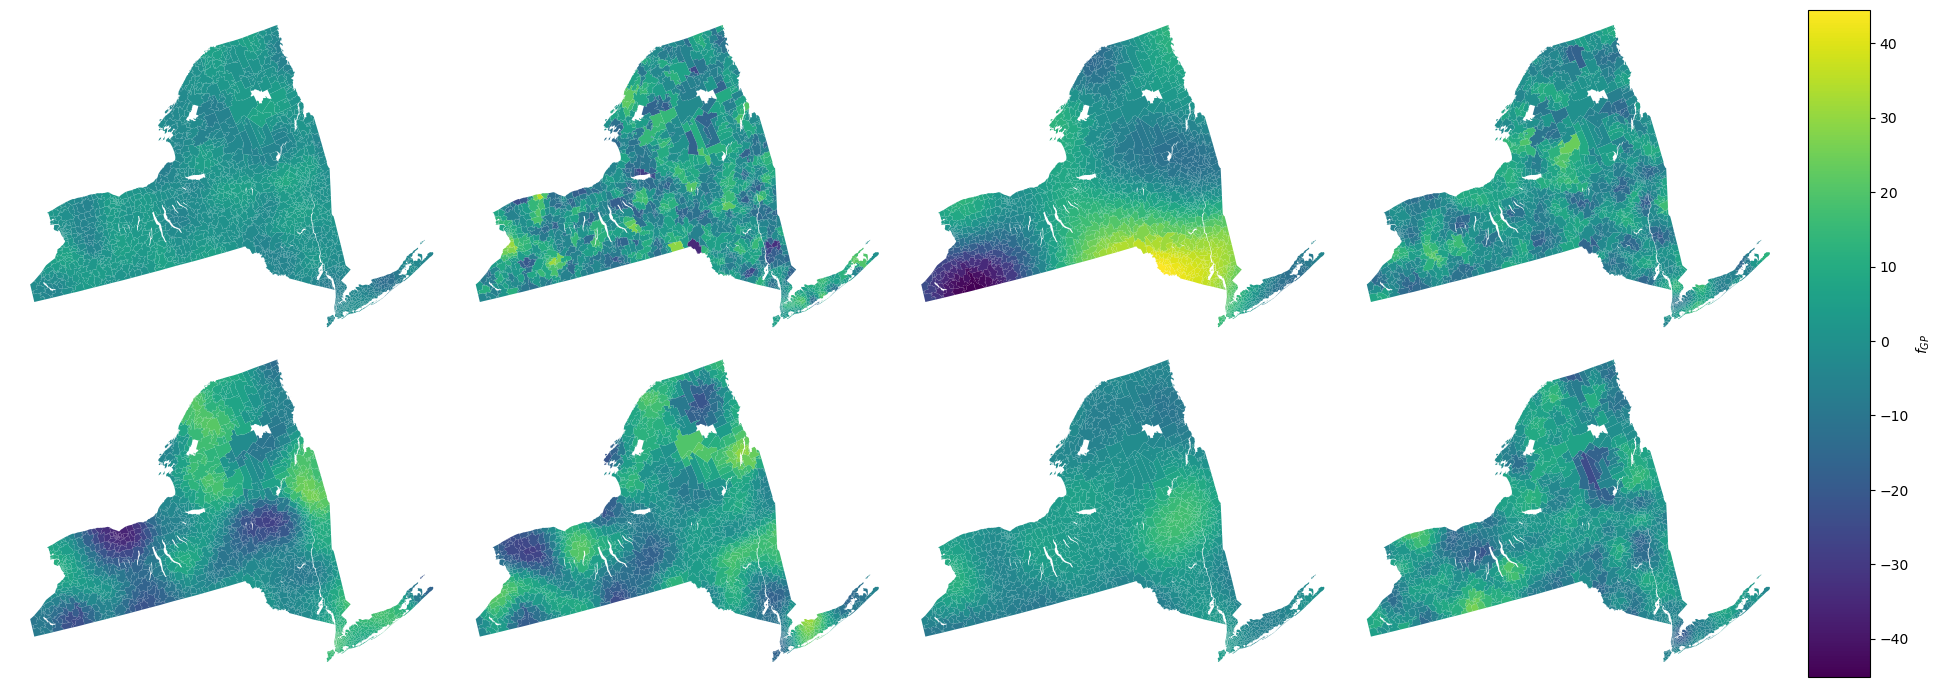

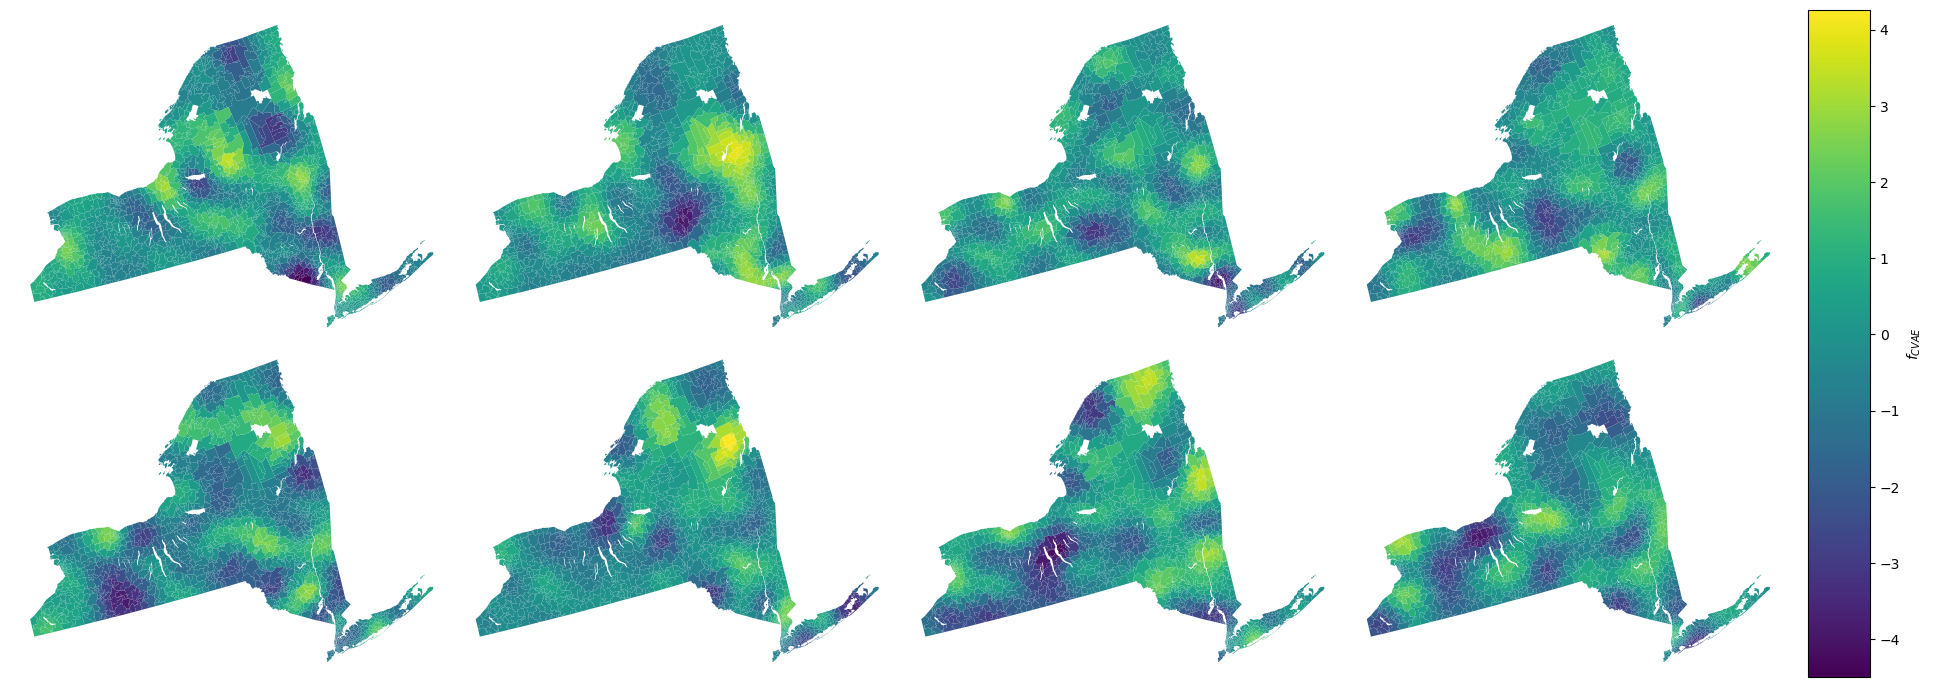

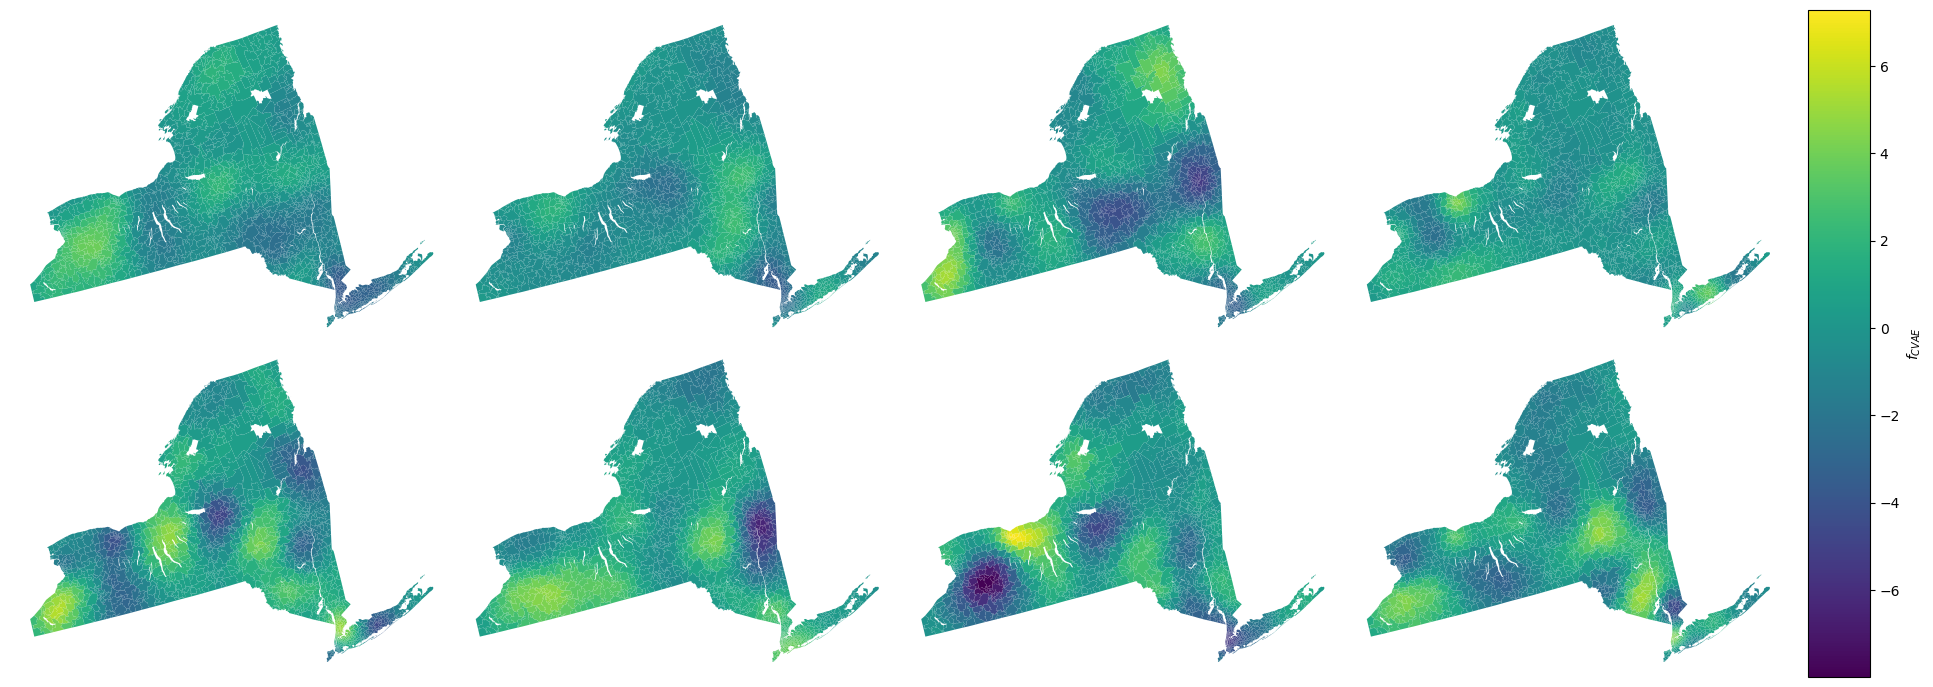

In [ ]:
plot_multi_on_state(gp_plot_samples["y"][:8], args["state"], "GP prior samples", "$f_{GP}$")

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    print(samples[loss_fn]["f"][:8].shape)
    plot_multi_on_state(samples[loss_fn]["f"][:8], args["state"], f"{loss_fn} VAE prior samples", "$f_{CVAE}$")


### Ground truth

In [ ]:
plot_on_state(args["ground_truth"], args["state"], "Ground truth", "HIV cases")
plot_draws(args["ground_truth"][None], jnp.arange(args["n"]), "Ground truth on a line", "GT")

## Masked ground truth

In [ ]:
plot_on_state(mask_for_plotting(args["ground_truth"], args["obs_idx"]), args["state"], "Masked ground truth", "GT")


### Inference

In [ ]:
vaes = {}


for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    gen_file_name(args["expcode"], args, "gp" if loss_fn is None else loss_fn)
    decoder_params = get_decoder_params(load_training_state(args["expcode"], file_name, dummy_state))

    vaes[loss_fn] = vae_mcmc(
            args["hidden_dim1"],
            args["hidden_dim2"],
            args["latent_dim"],
            decoder_params,
            obs_idx=args["obs_idx"],
            noise=True,
        )

In [ ]:
rng_key = random.PRNGKey(2345678)

load_mcmc = False

mcmc_samples = {}

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue

    if load_mcmc:
        mcmc_samples[loss_fn] = load_samples(args["expcode"], gen_file_name(args["expcode"], args, f"inference_{loss_fn}_mcmc", include_mcmc=True))
    
    else:


        rng_key, rng_key_mcmc = random.split(rng_key, 2)

        mcmc_samples[loss_fn] = run_mcmc(
            args["num_warmup"],
            1000, #args["num_samples"],
            args["num_chains"],
            rng_key_mcmc,
            vaes[loss_fn],
            {"x": args["x"],
            "y": args["ground_truth_y_obs"]},
            verbose=True,
            max_run_length=None
        )

    

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Done MCMC warmup run 1/1


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue

    fig = plt.figure(figsize=(24, 6))
    ax = fig.add_subplot()

    plot_one_inference(
        mcmc_samples[loss_fn]["f"],
        jnp.arange(0, args["x"].shape[0]),
        args["ground_truth"],
        args["obs_idx"],
        args["ground_truth_y_obs"],
        f"MCMC samples with {loss_fn}",
        "stupid",
        "VAE",
        _min=2.5,
        _max=15,
        ax=ax
    )



In [ ]:
means = [args["ground_truth"], mask_for_plotting(args["ground_truth"], args["obs_idx"])]
hpdis = []
titles = ["Ground Truth", "observed ground truth"]
for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue

    mean = jnp.mean(mcmc_samples[loss_fn]["f"], axis=0)
    hpdis.append(numpyro.diagnostics.hpdi(mcmc_samples[loss_fn]["f"], 0.95))
    means.append(mean)
    titles.append(loss_fn)

In [ ]:
plot_multi_on_state(jnp.array(means), 36, "Means", "??", titles, num_in_row=4)

In [ ]:
plot_multi_on_state(jnp.abs(jnp.array(means) - args["ground_truth"]), 36, "Difference", "??", titles, num_in_row=4)

In [ ]:
plot_on_state(mask_for_plotting(args["ground_truth"] - means[2], args["obs_idx"]), 36, "Difference on observed points", "temp")

In [ ]:
import numpy as onp
mask = onp.zeros((args["n"]))
mask[args["obs_idx"]] = 1

In [ ]:
plot_on_state(mask, 36, "Observed points", "observed = 1")

In [ ]:

plot_multi_on_state(onp.array([u-l for l,u in hpdis]), 36, "CI comparisons", "tmean",  [f"{x}: CI differences" for x in args["loss_fn_names"][1:]], edge_highlight_indices=args["obs_idx"])